In [1]:
import h5py
import tensorflow as tf
import numpy as np
import math
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, Model, Input #type: ignore


In [2]:
hdf5_file = "angles_data.h5"

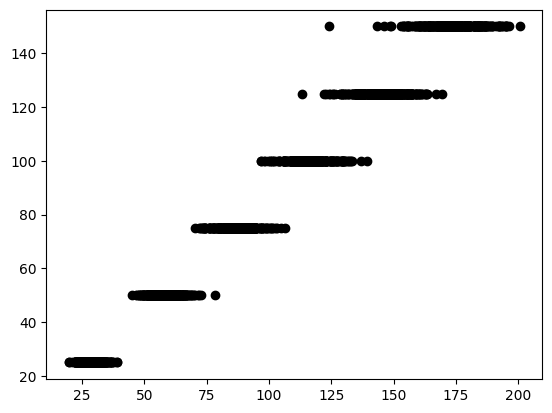

In [9]:
len = 900000

len = 2000
with h5py.File(hdf5_file,"r") as f:
    energy = f['energy']
    for k in range(len):
        plt.scatter(energy[:][k]/10,f["labels"][k],c="k");

plt.show()

In [4]:
def hdf5_generator():
    with h5py.File(hdf5_file, 'r') as f:
        data = f['data']
        labels = f['labels']
        num_samples = data.shape[0]
        
        for i in range(num_samples):
            yield data[i], labels[i]

In [4]:
def _fixup_shape(images, labels):
    images.set_shape([32, 20, 110, 11])
    labels.set_shape([32,])
    return images, labels

In [5]:
dataset = tf.data.Dataset.from_generator(
    hdf5_generator,
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
)
# Optimize the pipeline
dataset = (dataset
           .batch(32,drop_remainder=True)
           .map(_fixup_shape)
           .prefetch(tf.data.AUTOTUNE))
print("Data loaded")

Data loaded


In [6]:
test = dataset.take(1000)
train = dataset.skip(1000)

In [7]:
train.element_spec

(TensorSpec(shape=(32, 20, 110, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(32,), dtype=tf.int16, name=None))

In [9]:
model = models.Sequential([
    # Input layer
    layers.Input(shape=(20, 110, 11, 1)),
    
    # First 3D Convolutional layer
    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu'),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Second 3D Convolutional layer
    layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),
    
    # Flatten the 3D features
    layers.Flatten(),
    
    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    
    # Output layer (e.g., regression output or classification)
    layers.Dense(1, activation='linear')  # 'linear' for regression tasks
])

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # or 'categorical_crossentropy' for classification
              metrics=['mean_absolute_error'])

In [10]:
print("Training")
#Trening
history = model.fit(
    train,
    epochs=12,      # Number of training epochs
    #batch_size=16,  # Number of samples per batch - !! maybe too much because data is already batched !!
    shuffle=True,   # Shuffle training data at each epoch
    verbose=1       # Show training progress (1 = progress bar, 2 = epoch-only)
)
print("Training done")

Training
Epoch 1/12
   4603/Unknown 442s 88ms/step - loss: 285.7613 - mean_absolute_error: 5.9201

KeyboardInterrupt: 